In [61]:
import numpy as np
import torch
import h5py
import re
import torch.nn as nn 
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim



In [62]:
# hf = h5py.File("Smoke Flow Data.h5", "r")

In [63]:
# print(hf.keys())

In [64]:
# data = np.array(hf['x-50.0']['density'])

In [65]:
# data.shape

In [66]:
# data.shape

In [67]:
# smoke_detectors = np.array([[60.0, 60.0], [30.0,80.0]])

In [68]:
#Trying to find for all source for the given smoke detectors just the time and density is not enough to predict the source 



smoke_detectors = np.array([[60.0, 60.0],[30.0, 80.0]])

# Open the HDF5 file
with h5py.File('Smoke-Flow-Data.h5', 'r') as hf:
    # Initialize lists to store time, x, y, and density values
    all_time_values = []
    all_x_values = []
    all_y_values = []
    all_density_values = []
    all_source_values = []

    
    for smoke_detector_pos in smoke_detectors:
        x, y = smoke_detector_pos
        # Loop through groups in the file
        for source_group in hf.keys():
            group = hf[source_group]
            density_dataset = group['density']
            source_value = float(source_group.split('-')[-1])
    
            # Extract density value at time t, position (x, y)
            density_value = density_dataset[:, int(x), int(y), 0]  # assuming vector component 0

            # Append the source, time, x, y, and density values to the lists
            all_source_values.append(source_value)  
            # all_time_values.append(t)
            # all_x_values.append(x)
            # all_y_values.append(y)
            all_density_values.append(density_value)
            # print(source_value,t,density_value)


In [94]:
# # Convert lists to PyTorch tensors
source_tensor = torch.tensor(all_source_values, dtype=torch.float32)
density_tensor = torch.tensor(all_density_values, dtype=torch.float32)


In [95]:
# print(time_tensor.shape)
print(density_tensor.shape)
print(source_tensor.shape)

torch.Size([18, 501])
torch.Size([18])


In [96]:
density_tensor = density_tensor.view(9,2,-1)
source_tensor = source_tensor[0:9]
print(source_tensor.shape)

torch.Size([9])


In [97]:
# for i in range(density_tensor.size(0)):
#     print(f"Values in the first dimension (batch {i}): {density_tensor[i]}")
#     print("length",len(density_tensor[i]))

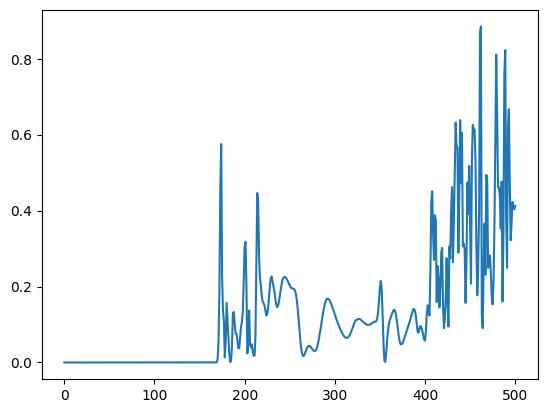

In [73]:
plt.plot(density_tensor[6,1,:])

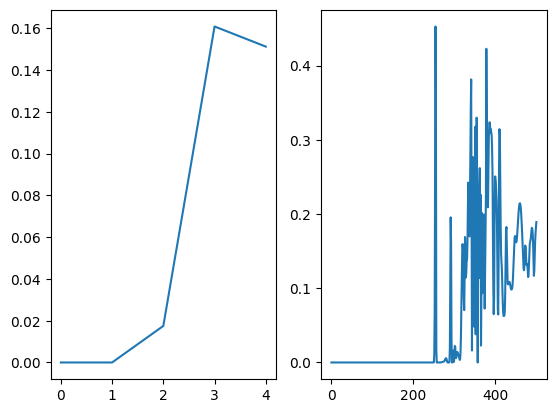

In [158]:
# import torch.nn as nn
my_test_layer = nn.AvgPool1d(100)
plt.subplot(121)
plt.plot(my_test_layer(density_tensor)[4,0,:])
plt.subplot(122)
plt.plot((density_tensor)[4,0,:])


In [98]:
# conv1d_layer = torch.nn.Conv1d(in_channels=2, out_channels =2 , kernel_size=9)
# source_tensor = torch.randn((9, 1))  # Assuming 1D output
# print(source_tensor.shape)
# print(len(density_tensor))

In [99]:
source_tensor

tensor([10., 20., 30., 40., 50., 60., 70., 80., 90.])

In [85]:
# Assuming you have separate training and testing datasets
num_samples = len(density_tensor)
split_ratio = 0.8
split_index = int(split_ratio * num_samples)

In [100]:
train_density = density_tensor[:split_index]
test_density = density_tensor[split_index:]
train_source = source_tensor[:split_index]
test_source = source_tensor[split_index:]


In [103]:
train_source

tensor([10., 20., 30., 40., 50., 60., 70.])

In [104]:
batch_size = 8

# Create DataLoader for training set
train_dataset = TensorDataset(train_density, train_source)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create DataLoader for testing set
test_dataset = TensorDataset(test_density, test_source)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [138]:
# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self, debug=0):
        super(SimpleCNN, self).__init__()

        self.debug = debug
        
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=4, kernel_size=3, stride=1, padding=1)

        self.relu1 = nn.ReLU()
    
        self.avgpool1 = nn.AvgPool1d(10)
        
        self.conv2 = nn.Conv1d(in_channels=4, out_channels=8, kernel_size=3, stride=1, padding=1)
    
        self.avgpool2 = nn.AvgPool1d(6)

        self.conv3 = nn.Conv1d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1)
       
        self.avgpool3 = nn.AvgPool1d(3)

        self.relu2 = nn.ReLU()
        

        self.conv4 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)

        self.relu3 = nn.ReLU()

        # Adjust the linear layer input size based on the number of output channels from the last convolutional layer
        # self.fc = nn.Linear(8, 16)
        
        self.flatten = nn.Flatten()
        self.linear_layer = nn.Linear(16, 1)

    def forward(self, x):

        x = self.conv1(x)
        x = self.relu1(x)
        x = self.avgpool1(x)
        
        x = self.conv2(x)
        # x = self.relu2(x)
        x = self.avgpool2(x)

        x = self.conv3(x)
        x = self.avgpool3(x)
        x = self.relu2(x)



        x = self.conv4(x)
        x = self.relu3(x)


        # print("Size before flattening:", x.size())  # Add this line to check the size

        x = self.flatten(x)
        if self.debug:
            print(x.shape)

        x = self.linear_layer(x)

        # print("Size before reshaping:", x.size())
        return x
# at some p[oint we can switch to classification (equivalent to detetchgfgndfjkgh the room where the smoke is)

In [139]:
# def lr_lambda(epoch):
#     # LR to be 0.1 * (1/1+0.01*epoch)
#     base_lr = 0.1
#     factor = 0.001
#     return base_lr/(1+factor*epoch)

In [144]:
# Create an instance of the model
model = SimpleCNN(debug=0)
## List for loss
train_losses = []
test_losses = []

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Learning rate scheduler
# scheduler = optim.lr_scheduler.LambdaLR(optimizer,lr_lambda)  # Adjust step_size and gamma as needed


In [151]:


# Training loop
epochs = 2000
for epoch in range(epochs):
    model.train()
    for density_batch, source_batch in train_loader:
        # # Forward pass
        # print(density_batch.shape)
        outputs = model(density_batch)

        # print(outputs.shape, source_batch.shape)

        # Compute loss
        loss = criterion(outputs, source_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Learning rate scheduler step
    # scheduler.step()
    
#     if epoch % 10 == 0:
#         print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item()}')

# # Testing loop
#     model.eval()
# with torch.no_grad():
#     for density_batch, source_batch in test_loader:
#         test_outputs = model(density_batch)
#         test_loss = criterion(test_outputs, source_batch)
        

# After training and testing, you can use the model to make predictions
predicted_sources = model(density_tensor)

In [141]:
model.debug = 0

In [154]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

1333

In [148]:
source_batch

tensor([80., 90.])